In [1]:
import torch

from tqdm import tqdm
device = torch.device("cuda")

In [2]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

# Using pretrained weights:
weights = MobileNet_V3_Large_Weights.IMAGENET1K_V2
model = mobilenet_v3_large(weights=weights).to(device)
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(960, 960, bias=False),
    torch.nn.BatchNorm1d(960),
    torch.nn.Dropout(p=0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(960, 960, bias=False),
    torch.nn.BatchNorm1d(960),
    torch.nn.Dropout(p=0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(960, 7),
).to(device)

model.classifier.load_state_dict(torch.load("color_mobile_layers.pt"))

print("Loaded updated model")

Loaded updated model


In [3]:
import torch

optimizer = torch.optim.AdamW(params=[p for p in model.parameters() if p.requires_grad], lr=1e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.2)

criterion = torch.nn.CrossEntropyLoss()

losses = []
val_losses = []

sum(p.numel() for p in model.parameters())

4825719

In [4]:
import os
import pandas as pd
from torchvision.io import read_image
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as T

class CountingDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path, ) / 255.0
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
    
annotations_file = "../Apple/counting/train/train_ground_truth.txt"
img_dir = "../Apple/counting/train/images/"
transform = T.Compose([
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    T.Resize((224,224), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = CountingDataset(annotations_file, img_dir, transform=transform)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_annotations_file = "../Apple/counting/val/val_ground_truth.txt"
val_img_dir = "../Apple/counting/val/images/"
val_transform = T.Compose([
    T.Resize((224,224), antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_dataset = CountingDataset(val_annotations_file, val_img_dir, transform=val_transform)

val_batch_size = 16
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [5]:
num_epochs = 20

for epoch in (range(num_epochs)):
    prev_target = None
    model.train()
    for batch_input, batch_target in tqdm(train_dataloader):

        if batch_input.shape[0] < batch_size:
            continue

        optimizer.zero_grad()

        pred = model(batch_input.to(device))

        loss = criterion(pred, batch_target.to(device))

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        prev_target = batch_target

    model.eval()
    with torch.no_grad():
        val_num_examples = 0.0
        val_num_apples = 0
        for val_input, val_target in (val_dataloader):
            val_pred = model(val_input.to(device))
            val_error = torch.abs(val_target-val_pred.argmax(dim=1).cpu())
            val_num_apples += torch.sum(val_error).item()
            val_num_examples += torch.count_nonzero(val_error).item()
        val_losses.append((val_num_examples, val_num_apples))
        print((val_num_examples, val_num_apples))

    torch.save(model.state_dict(), f"mobile_states/epoch{epoch+1}.pt")
    lr_scheduler.step()

100%|██████████| 4038/4038 [04:11<00:00, 16.08it/s]


(865.0, 1047)


100%|██████████| 4038/4038 [04:10<00:00, 16.09it/s]


(537.0, 636)


100%|██████████| 4038/4038 [04:20<00:00, 15.52it/s]


(438.0, 502)


100%|██████████| 4038/4038 [04:17<00:00, 15.71it/s]


(302.0, 354)


100%|██████████| 4038/4038 [04:09<00:00, 16.17it/s]


(250.0, 280)


100%|██████████| 4038/4038 [04:10<00:00, 16.13it/s]


(176.0, 200)


100%|██████████| 4038/4038 [04:09<00:00, 16.16it/s]


(166.0, 190)


100%|██████████| 4038/4038 [04:43<00:00, 14.26it/s]


(165.0, 186)


 17%|█▋        | 673/4038 [00:46<04:04, 13.77it/s]

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

0.019288595963600264


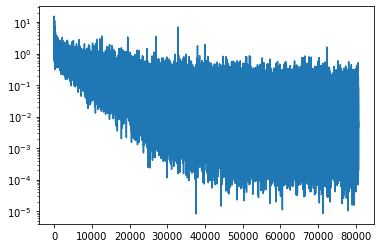

In [ ]:
plt.semilogy(losses)
print(np.mean(losses[-len(train_dataset)//batch_size:]))

[(554.0, 665),
 (432.0, 529),
 (310.0, 352),
 (236.0, 261),
 (193.0, 217),
 (133.0, 146),
 (123.0, 137),
 (118.0, 133),
 (123.0, 135),
 (121.0, 132),
 (114.0, 125),
 (107.0, 119),
 (102.0, 113),
 (104.0, 116),
 (109.0, 120),
 (106.0, 118),
 (106.0, 118),
 (113.0, 125),
 (109.0, 120),
 (106.0, 117)]

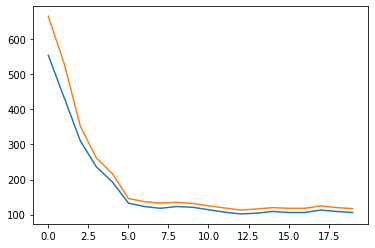

In [ ]:
plt.plot([x[0] for x in val_losses])
plt.plot([x[1] for x in val_losses])
val_losses

[(554.0, 665),
 (432.0, 529),
 (310.0, 352),
 (236.0, 261),
 (193.0, 217),
 (133.0, 146),
 (123.0, 137),
 (118.0, 133),
 (123.0, 135),
 (121.0, 132),
 (114.0, 125),
 (107.0, 119),
 (102.0, 113),
 (104.0, 116),
 (109.0, 120),
 (106.0, 118),
 (106.0, 118),
 (113.0, 125),
 (109.0, 120),
 (106.0, 117)]

In [ ]:
val_losses[-1][0] / len(val_dataset)

0.03122238586156112